# Mutation Effect Prediction with ESM-2

Predicting how mutations affect protein function is a fundamental challenge in protein engineering,
drug design, and understanding disease. Traditional approaches require expensive experiments for each
variant. But what if we could predict mutation effects computationally, using only sequence information?

**ESM-2**, trained on 65 million protein sequences, has learned deep patterns about which amino acid
combinations are biologically plausible. We can leverage this knowledge to score mutations in a
**zero-shot** manner - without any experimental data for the specific protein!

This notebook demonstrates three complementary approaches:

1. **Mutation Heatmap**: Visualize effects of ALL possible mutations across a sequence
2. **Deep Mutational Scanning (DMS)**: Score specific mutations from a list
3. **Pseudo-Perplexity (PPPL)**: Evaluate overall sequence quality/naturalness

## Real-World Applications

- **Protein Engineering**: Identify stabilizing mutations for therapeutic antibodies
- **Disease Genetics**: Predict pathogenicity of genetic variants
- **Directed Evolution**: Prioritize mutations for experimental screening
- **Antibody Optimization**: Improve binding affinity, reduce immunogenicity
- **Quality Control**: Evaluate designed sequences before synthesis

## Learning Objectives

By the end of this notebook, you will:
1. Understand log-likelihood ratios (LLRs) for mutation scoring
2. Create comprehensive mutation heatmaps
3. Implement three mutation scoring strategies (wild-type, masked, pseudo-perplexity)
4. Choose appropriate ESM-2 model sizes for different tasks
5. Interpret scores in biological context
6. Apply these methods to real protein engineering problems

**Note**: This notebook is completely self-contained and designed to run on Google Colab with a single GPU.

## Setup and Installation

First, let's install all required packages and set up our environment.

In [1]:
# Install required packages (uncomment if running on Colab)
!pip install -q transformers torch matplotlib numpy pandas biopython tqdm ipywidgets cmocean

# Standard library imports
import os
import string
import itertools
from pathlib import Path
from collections import defaultdict

# Core scientific computing
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Progress bars
from tqdm.auto import tqdm

# Hugging Face Transformers
from transformers import AutoTokenizer, EsmForMaskedLM, AutoModelForMaskedLM

# BioPython for sequence handling
from Bio import SeqIO
from Bio.Seq import Seq

# Jupyter widgets for interactive features
import ipywidgets as widgets
from IPython.display import display, HTML

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.5 MB/s eta 0:00:00
Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.17 GB


## Understanding Mutation Scoring with Log-Likelihood Ratios

### The Core Idea

ESM-2 learns to predict masked amino acids. We can use these predictions to score mutations:

**Log-Likelihood Ratio (LLR)** = log P(mutant | context) - log P(wild-type | context)

### Interpretation

- **Negative LLR** (< 0): Mutation decreases sequence likelihood → Likely **deleterious**
- **LLR ≈ 0**: Mutation neutral → **Tolerated**
- **Positive LLR** (> 0): Mutation increases likelihood → Potentially **beneficial**

### Intuition

Think of ESM-2 as having "read" 65 million proteins. It knows which amino acid patterns are
common (evolutionary conserved) and which are rare (likely harmful). The LLR quantifies this.

### Simple Example

Original: `MKTAY`**K**`AKQR` (position 6 = K)
Mutation: `MKTAY`**R**`AKQR` (K6R)

1. Mask position 6: `MKTAY[MASK]AKQR`
2. ESM-2 predicts: P(K) = 0.45, P(R) = 0.35
3. LLR = log(0.35) - log(0.45) = -0.25
4. Interpretation: K6R slightly deleterious (negative LLR)

## Part 1: Load ESM-2 Model

ESM-2 comes in multiple sizes. Choose based on your needs:

| Model | Parameters | Layers | Speed | Accuracy | GPU Memory | Use Case |
|-------|-----------|--------|-------|----------|------------|----------|
| t6_8M | 8M | 6 | Fastest | Good | ~1 GB | Quick prototyping |
| t12_35M | 35M | 12 | Fast | Better | ~2 GB | **Recommended for Colab** |
| t30_150M | 150M | 30 | Medium | Great | ~4 GB | Production (small GPU) |
| t33_650M | 650M | 33 | Slow | Excellent | ~8 GB | Production (large GPU) |
| t36_3B | 3B | 36 | Very slow | Best | ~16 GB | Research |

We'll use **t12_35M** for good balance of speed and accuracy on Colab.

In [2]:
# Load model and tokenizer
model_name = "facebook/esm2_t12_35M_UR50D"  # 35M parameter model (fast, accurate)

print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)

# Move to GPU
model = model.to(device)
model.eval()

print(f"\nModel loaded successfully!")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Layers: {model.config.num_hidden_layers}")
print(f"  Embedding dim: {model.config.hidden_size}")
print(f"  Vocabulary size: {model.config.vocab_size}")

# Get mask token ID
mask_token_id = tokenizer.mask_token_id
print(f"  Mask token ID: {mask_token_id}")

Loading facebook/esm2_t12_35M_UR50D...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]


Model loaded successfully!
  Parameters: 33,501,394
  Layers: 12
  Embedding dim: 480
  Vocabulary size: 33
  Mask token ID: 32


## Part 2: Example Protein Sequence

Let's work with a real antibody complementarity-determining region (CDR) sequence.
This is where antibodies bind to antigens, so mutations here significantly affect function.

In [37]:
# Example: Antibody CDR-H3 region (highly variable, critical for binding)
wild_type_sequence = "EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKG"

print(f"Wild-type sequence:")
print(f"  Length: {len(wild_type_sequence)} amino acids")
print(f"  Sequence: {wild_type_sequence}")
print(f"\nThis is an antibody heavy chain variable region.")
print(f"Mutations in this region can affect:")
print(f"  - Antigen binding specificity")
print(f"  - Binding affinity")
print(f"  - Protein stability")
print(f"  - Immunogenicity")

Wild-type sequence:
  Length: 66 amino acids
  Sequence: EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKG

This is an antibody heavy chain variable region.
Mutations in this region can affect:
  - Antigen binding specificity
  - Binding affinity
  - Protein stability
  - Immunogenicity


## Part 3: Approach 1 - Comprehensive Mutation Heatmap

Let's create a **mutation landscape** showing the predicted effect of EVERY possible single
amino acid substitution. This gives us a complete picture of which positions are conserved
and which tolerate mutations.

In [38]:
def compute_mutation_scores(sequence, model, tokenizer, device):
    """
    Compute log-likelihood ratios for all possible single mutations.

    Args:
        sequence: Wild-type protein sequence (string)
        model: ESM model for masked language modeling
        tokenizer: ESM tokenizer
        device: torch device

    Returns:
        scores: (20, len(sequence)) array of LLRs
        amino_acids: List of 20 standard amino acids
    """
    # Standard amino acids
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

    # Initialize score matrix
    n_positions = len(sequence)
    n_amino_acids = len(amino_acids)
    scores = np.zeros((n_amino_acids, n_positions))

    model.eval()

    # Process each position
    for pos in tqdm(range(n_positions), desc="Computing scores"):
        # Create masked sequence
        masked_seq = sequence[:pos] + tokenizer.mask_token + sequence[pos+1:]

        # Tokenize
        tokens = tokenizer(masked_seq, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}

        # Get predictions
        with torch.no_grad():
            outputs = model(**tokens)
            logits = outputs.logits

        # Find the masked position in tokens (accounting for <cls> token at position 0)
        mask_token_index = (tokens['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # Get log probabilities at masked position
        log_probs = F.log_softmax(logits[0, mask_token_index[0]], dim=0)

        # Get wild-type amino acid
        wt_amino_acid = sequence[pos]
        wt_token_id = tokenizer.convert_tokens_to_ids(wt_amino_acid)
        wt_log_prob = log_probs[wt_token_id].item()

        # Compute LLR for each possible mutation
        for i, mutant_aa in enumerate(amino_acids):
            mutant_token_id = tokenizer.convert_tokens_to_ids(mutant_aa)
            mutant_log_prob = log_probs[mutant_token_id].item()

            # LLR = log P(mutant) - log P(wt)
            llr = mutant_log_prob - wt_log_prob
            scores[i, pos] = llr

    return scores, amino_acids

### Compute Scores for Our Example Sequence

This will take a few minutes depending on sequence length and GPU.

In [39]:
print("Computing mutation scores for all positions...")
print(f"This will evaluate {len(wild_type_sequence)} positions × 20 amino acids = {len(wild_type_sequence) * 20} mutations")

mutation_scores, amino_acids = compute_mutation_scores(
    wild_type_sequence,
    model,
    tokenizer,
    device
)

print(f"\nDone! Score matrix shape: {mutation_scores.shape}")
print(f"  Rows: {len(amino_acids)} amino acids")
print(f"  Columns: {len(wild_type_sequence)} positions")

Computing mutation scores for all positions...
This will evaluate 66 positions × 20 amino acids = 1320 mutations


Computing scores:   0%|          | 0/66 [00:00<?, ?it/s]


Done! Score matrix shape: (20, 66)
  Rows: 20 amino acids
  Columns: 66 positions


### Visualize the Mutation Heatmap

Now let's create a beautiful heatmap showing the mutation landscape.

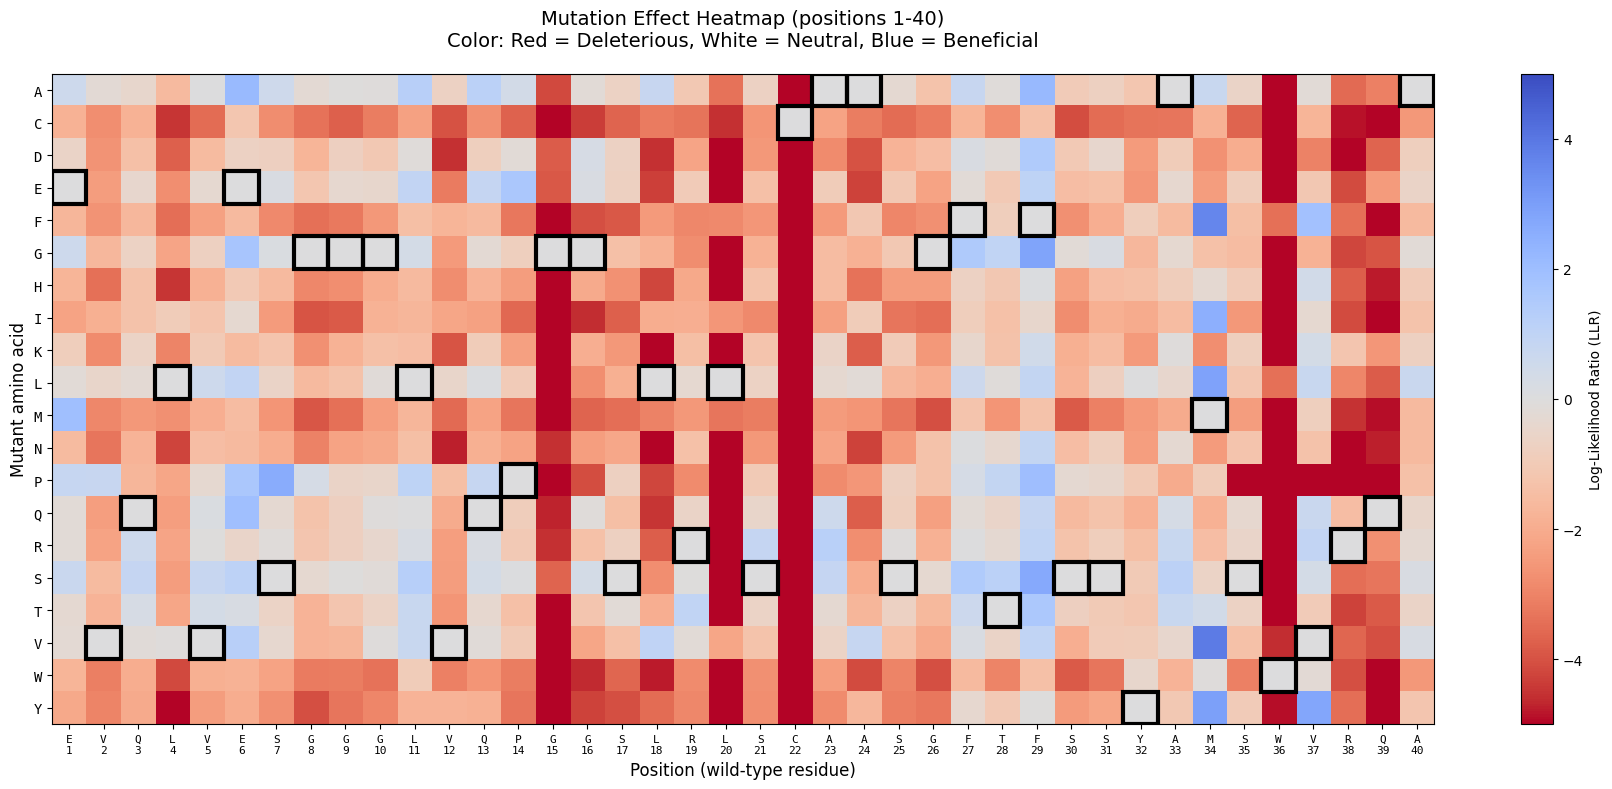


Interpretation:
  - Black boxes: Wild-type amino acid at each position
  - Dark red: Highly deleterious mutations (LLR < -2)
  - White: Neutral mutations (LLR ≈ 0)
  - Dark Blue: Potentially beneficial mutations (LLR > 0)
  - Vertical dark red columns: Highly conserved positions


In [40]:
def plot_mutation_heatmap(scores, amino_acids, sequence, start_pos=0, end_pos=None, figsize=(16, 8)):
    """
    Plot mutation heatmap with interactive region selection.

    Args:
        scores: (n_amino_acids, n_positions) LLR matrix
        amino_acids: List of amino acid letters
        sequence: Wild-type sequence
        start_pos: Start position to display (0-indexed)
        end_pos: End position to display (None = all)
        figsize: Figure size
    """
    if end_pos is None:
        end_pos = len(sequence)

    # Subset scores
    scores_subset = scores[:, start_pos:end_pos]
    seq_subset = sequence[start_pos:end_pos]

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot heatmap
    im = ax.imshow(scores_subset, aspect='auto', cmap="coolwarm_r", vmin=-5, vmax=5)

    # Set ticks
    ax.set_xticks(range(len(seq_subset)))
    ax.set_xticklabels([f"{seq_subset[i]}\n{start_pos+i+1}" for i in range(len(seq_subset))],
                        fontsize=8, family='monospace')
    ax.set_yticks(range(len(amino_acids)))
    ax.set_yticklabels(amino_acids, fontsize=10, family='monospace')

    ax.set_xlabel("Position (wild-type residue)", fontsize=12)
    ax.set_ylabel("Mutant amino acid", fontsize=12)
    ax.set_title(f"Mutation Effect Heatmap (positions {start_pos+1}-{end_pos})\n" +
                 "Color: Red = Deleterious, White = Neutral, Blue = Beneficial",
                 fontsize=14, pad=20)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label="Log-Likelihood Ratio (LLR)")
    cbar.ax.tick_params(labelsize=10)

    # Highlight wild-type residues
    for pos_idx in range(len(seq_subset)):
        wt_aa = seq_subset[pos_idx]
        aa_idx = amino_acids.index(wt_aa)
        rect = plt.Rectangle((pos_idx - 0.5, aa_idx - 0.5), 1, 1,
                             fill=False, edgecolor='black', linewidth=3)
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Plot full heatmap (may be wide for long sequences)
plot_mutation_heatmap(mutation_scores, amino_acids, wild_type_sequence,
                      start_pos=0, end_pos=40, figsize=(18, 8))

print("\nInterpretation:")
print("  - Black boxes: Wild-type amino acid at each position")
print("  - Dark red: Highly deleterious mutations (LLR < -2)")
print("  - White: Neutral mutations (LLR ≈ 0)")
print("  - Dark Blue: Potentially beneficial mutations (LLR > 0)")
print("  - Vertical dark red columns: Highly conserved positions")

/tmp/ipython-input-3923163336.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=9)


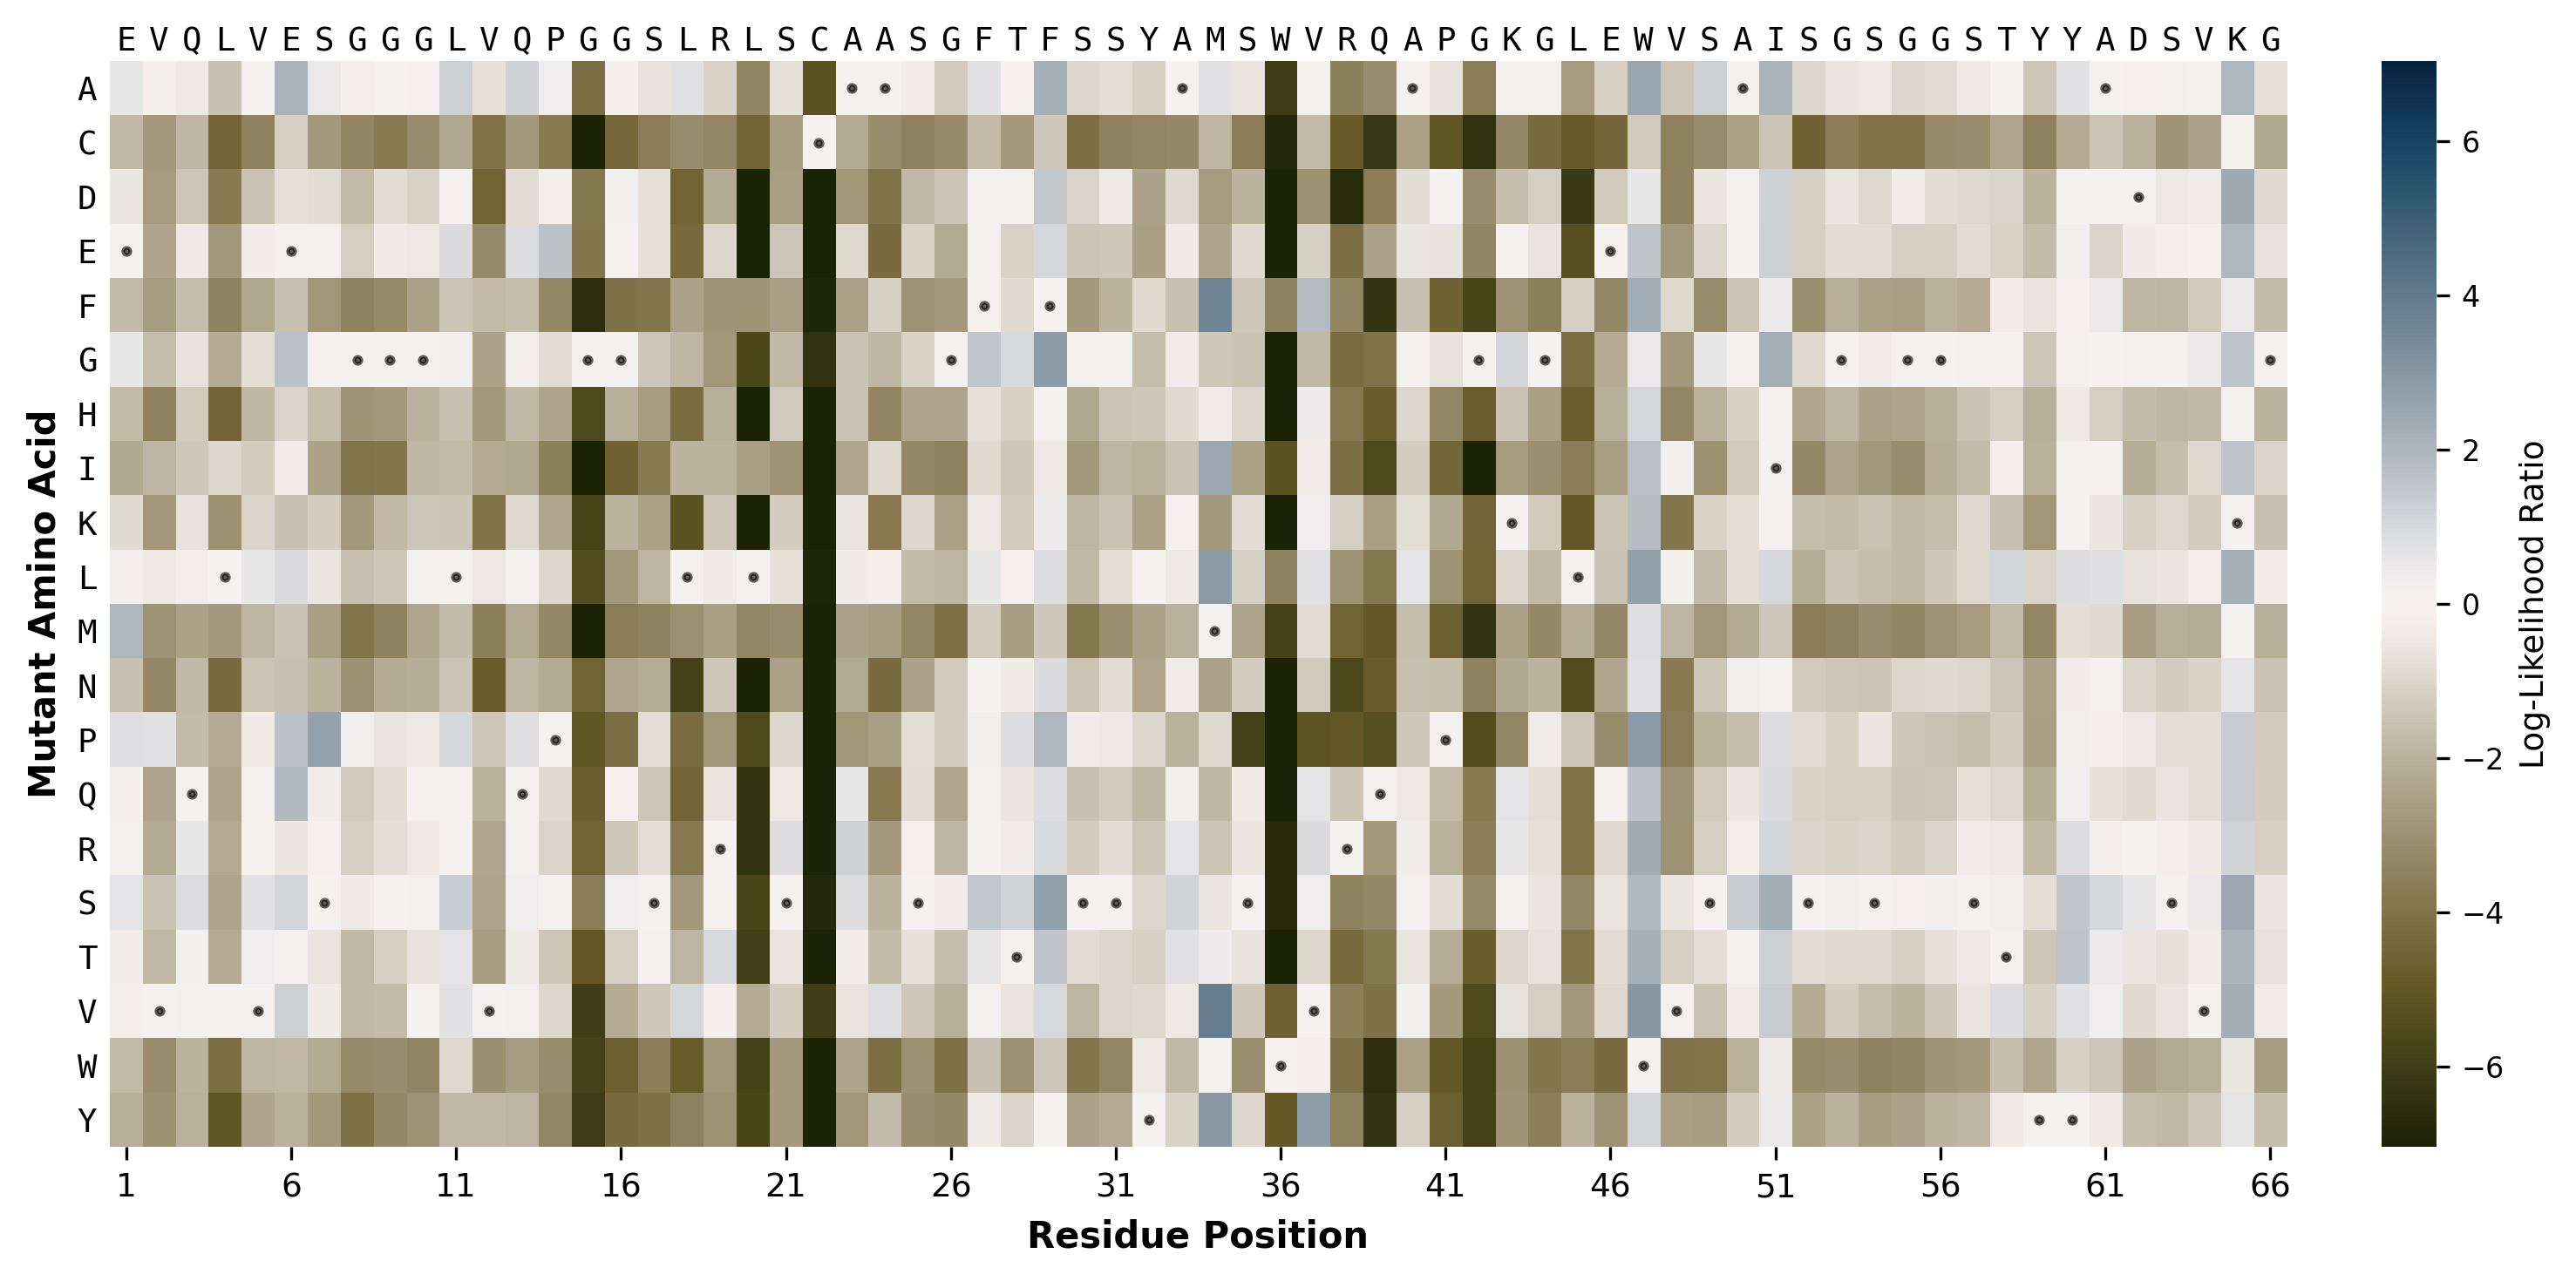

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import numpy as np
import cmocean

def plot_mutation_heatmap_pub(scores, amino_acids, sequence,
                            start_pos=0, end_pos=None, ax=None):
    """
    Publication-ready mutation heatmap using cmocean.
    """
    if end_pos is None:
        end_pos = len(sequence)

    # 1. Data Subsetting
    scores_subset = scores[:, start_pos:end_pos]
    seq_subset = sequence[start_pos:end_pos]
    n_pos = len(seq_subset)
    n_aa = len(amino_acids)

    # 2. Setup Figure (allow passing an axis for subplotting)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6)) # Standard textbook aspect ratio

    # 3. Color Normalization (CRITICAL for difference maps)
    # This ensures 0 is always white, even if min is -6 and max is +2
    max_abs = np.nanmax(np.abs(scores_subset))
    norm = colors.TwoSlopeNorm(vmin=-max_abs+3, vcenter=0, vmax=max_abs-3)

    # 4. Plotting
    # Use cmocean.cm.diff_r (Blue=Beneficial, Brown=Deleterious usually)
    im = ax.imshow(scores_subset, aspect='auto', cmap=cmocean.cm.diff_r,
                   norm=norm, interpolation='nearest')

    # 5. Typographic & Tick Polish
    # Y-Axis: Monospace for alignment, lighter color for ticks
    ax.set_yticks(range(n_aa))
    ax.set_yticklabels(amino_acids, family='monospace', fontsize=9)
    ax.tick_params(axis='y', length=0) # Remove tick marks, keep labels

    # X-Axis: Logic to prevent overcrowding
    ax.set_xticks(range(n_pos))
    # Only label every 5th position if the sequence is long
    if n_pos > 20:
        major_locator = ticker.MultipleLocator(5)
        ax.xaxis.set_major_locator(major_locator)
        # Create labels based on the locator
        locs = ax.get_xticks()
        labels = [f"{start_pos + int(x) + 1}" for x in locs if x < n_pos]
        ax.set_xticklabels(labels, fontsize=9)
    else:
        # If short, show all numbers
        ax.set_xticklabels([str(start_pos + i + 1) for i in range(n_pos)], fontsize=9)

    ax.set_xlabel("Residue Position", fontsize=10, weight='bold')
    ax.set_ylabel("Mutant Amino Acid", fontsize=10, weight='bold')

    # 6. Mark Wild-Type (The "Textbook" way)
    # Instead of a box, we use a dot. It allows the color to be seen
    # and handles grayscale printing better than a black box border.
    wt_x = []
    wt_y = []
    for i, wt_aa in enumerate(seq_subset):
        if wt_aa in amino_acids:
            row_idx = amino_acids.index(wt_aa)
            wt_x.append(i)
            wt_y.append(row_idx)

    # Plot dots for WT
    ax.scatter(wt_x, wt_y, marker='.', s=15, c='black', alpha=0.6, label='Wild Type')

    # 7. Add Wild-Type Sequence on Top (Optional but helpful context)
    # Creates a secondary axis just to show the letters
    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(range(n_pos))
    ax_top.set_xticklabels(list(seq_subset), family='monospace', fontsize=9)
    ax_top.tick_params(axis='x', length=0, pad=1)
    ax_top.spines['top'].set_visible(False)

    # 8. Clean Spines
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    # 9. Professional Colorbar
    # Create a concise colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Log-Likelihood Ratio", fontsize=9)
    cbar.outline.set_visible(False) # Remove box around colorbar
    cbar.ax.tick_params(labelsize=8)

    return ax

# --- Usage ---
fig, ax = plt.subplots(figsize=(10, 5), dpi=300) # High DPI for print
plot_mutation_heatmap_pub(mutation_scores, amino_acids, wild_type_sequence, ax=ax)

plt.tight_layout()
plt.savefig("mutation_heatmap.png", dpi=300, bbox_inches='tight') # Saves the file
plt.savefig("mutation_heatmap.svg", bbox_inches='tight')
plt.show()

### Interactive Region Selector

For long sequences, we can interactively zoom into specific regions.

In [7]:
def create_interactive_heatmap(scores, amino_acids, sequence):
    """Create interactive widget to explore different regions."""

    # Create slider
    slider = widgets.IntRangeSlider(
        value=[0, min(50, len(sequence))],
        min=0,
        max=len(sequence),
        step=1,
        description='Region:',
        continuous_update=False,
        layout=widgets.Layout(width='600px')
    )

    def update_plot(change):
        start, end = slider.value
        print(f"\nDisplaying positions {start+1} to {end}")
        plot_mutation_heatmap(scores, amino_acids, sequence, start, end, figsize=(16, 8))

    slider.observe(update_plot, names='value')

    display(slider)
    # Initial plot
    update_plot(None)

# Uncomment to enable interactive mode
# create_interactive_heatmap(mutation_scores, amino_acids, wild_type_sequence)

### Identify Highly Conserved Positions

Positions where most mutations are deleterious are likely functionally critical.

In [8]:
def analyze_conservation(scores, sequence, amino_acids, threshold=-1.0):
    """
    Identify conserved positions based on mutation intolerance.

    Args:
        scores: LLR matrix
        sequence: Wild-type sequence
        amino_acids: List of amino acids
        threshold: LLR threshold for calling a mutation deleterious

    Returns:
        DataFrame with conservation analysis
    """
    results = []

    for pos in range(len(sequence)):
        wt_aa = sequence[pos]
        pos_scores = scores[:, pos]

        # Exclude wild-type from analysis
        wt_idx = amino_acids.index(wt_aa)
        mutation_scores = np.delete(pos_scores, wt_idx)

        # Statistics
        mean_score = mutation_scores.mean()
        min_score = mutation_scores.min()
        max_score = mutation_scores.max()
        deleterious_count = (mutation_scores < threshold).sum()
        beneficial_count = (mutation_scores > 0).sum()

        results.append({
            'Position': pos + 1,
            'Wild-Type': wt_aa,
            'Mean LLR': mean_score,
            'Min LLR': min_score,
            'Max LLR': max_score,
            'Deleterious (%)': 100 * deleterious_count / len(mutation_scores),
            'Beneficial (%)': 100 * beneficial_count / len(mutation_scores),
        })

    return pd.DataFrame(results)

# Analyze conservation
conservation_df = analyze_conservation(mutation_scores, wild_type_sequence, amino_acids)

# Display most conserved positions (highest % deleterious)
print("Most conserved positions (intolerant to mutations):")
print("=" * 70)
most_conserved = conservation_df.nlargest(10, 'Deleterious (%)')
print(most_conserved.to_string(index=False))

print("\n\nMost variable positions (tolerant to mutations):")
print("=" * 70)
most_variable = conservation_df.nsmallest(10, 'Deleterious (%)')
print(most_variable.to_string(index=False))

Most conserved positions (intolerant to mutations):
 Position Wild-Type  Mean LLR    Min LLR   Max LLR  Deleterious (%)  Beneficial (%)
       15         G -5.400752  -8.010598 -3.652623       100.000000             0.0
       20         L -5.505005  -8.636205 -2.185047       100.000000             0.0
       22         C -8.000495 -10.038054 -5.181163       100.000000             0.0
       36         W -6.718863  -9.665546 -3.424041       100.000000             0.0
       38         R -3.906614  -6.649859 -1.179220       100.000000             0.0
       39         Q -4.424625  -6.514099 -2.454134       100.000000             0.0
       42         G -4.778588  -7.117793 -3.158075       100.000000             0.0
       45         L -3.687996  -6.145546 -1.163334       100.000000             0.0
       26         G -2.278103  -4.032889 -0.323948        94.736842             0.0
        4         L -2.849191  -5.039098 -0.042070        89.473684             0.0


Most variable position

## Part 4: Approach 2 - Deep Mutational Scanning (DMS)

In practice, we often have a **specific list of mutations** to evaluate (e.g., from experimental
screens or computational design). Instead of computing all possible mutations, we can score
just the variants we care about.

### Three Scoring Strategies

1. **Wild-Type Marginals** (`wt-marginals`): Single forward pass, fast but less accurate
2. **Masked Marginals** (`masked-marginals`): Mask each position, slower but **best performance**
3. **Pseudo-Perplexity** (`pseudo-ppl`): Evaluate entire mutated sequence

### Create Example Mutations

Let's create a list of mutations to score. Format: `{wt}{position}{mutant}`
Example: `A5G` means position 5, wild-type A, mutant G.

In [9]:
# Create example mutations
example_mutations = [
    "E1Q",   # Position 1: E → Q (conservative, both charged)
    "E1W",   # Position 1: E → W (radical, charged to hydrophobic)
    "V3L",   # Position 3: V → L (conservative, both hydrophobic)
    "L5P",   # Position 5: L → P (proline, often disruptive)
    "S15A",  # Position 15: S → A (remove hydroxyl)
    "G17P",  # Position 17: G → P (glycine to proline, reduce flexibility)
    "A25G",  # Position 25: A → G (both small)
    "Y30F",  # Position 30: Y → F (remove hydroxyl from aromatic)
    "K46R",  # Position 46: K → R (both positive, conservative)
    "D50N",  # Position 50: D → N (negative to neutral)
]

print("Example mutations to score:")
for mut in example_mutations:
    wt = mut[0]
    pos = int(mut[1:-1])
    mt = mut[-1]
    actual_wt = wild_type_sequence[pos-1]
    print(f"  {mut:8s} - Position {pos:2d}: {actual_wt} → {mt}")
    if wt != actual_wt:
        print(f"           WARNING: Expected {wt} but sequence has {actual_wt}")

Example mutations to score:
  E1Q      - Position  1: E → Q
  E1W      - Position  1: E → W
  V3L      - Position  3: Q → L
  L5P      - Position  5: V → P
  S15A     - Position 15: G → A
  G17P     - Position 17: S → P
  A25G     - Position 25: S → G
  Y30F     - Position 30: S → F
  K46R     - Position 46: E → R
  D50N     - Position 50: A → N


### Implementation: Masked Marginals Strategy

This is the **recommended** approach - mask each mutation position separately for accurate scoring.

In [10]:
def score_mutations_masked_marginals(mutations, sequence, model, tokenizer, device):
    """
    Score mutations using masked marginals strategy (recommended).

    For each mutation:
        1. Mask the mutation position
        2. Get model predictions
        3. Compute LLR = log P(mutant) - log P(wt)

    Args:
        mutations: List of mutation strings (e.g., ["A5G", "L10P"])
        sequence: Wild-type sequence
        model: ESM model
        tokenizer: ESM tokenizer
        device: torch device

    Returns:
        DataFrame with mutation scores
    """
    results = []

    model.eval()

    for mutation in tqdm(mutations, desc="Scoring mutations"):
        # Parse mutation
        wt_aa = mutation[0]
        pos = int(mutation[1:-1]) - 1  # Convert to 0-indexed
        mt_aa = mutation[-1]

        # Validate
        if sequence[pos] != wt_aa:
            print(f"Warning: {mutation} - expected {wt_aa} but found {sequence[pos]} at position {pos+1}")
            continue

        # Create masked sequence
        masked_seq = sequence[:pos] + tokenizer.mask_token + sequence[pos+1:]

        # Tokenize
        tokens = tokenizer(masked_seq, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}

        # Get predictions
        with torch.no_grad():
            outputs = model(**tokens)
            logits = outputs.logits

        # Find masked position
        mask_idx = (tokens['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1][0]

        # Get log probabilities
        log_probs = F.log_softmax(logits[0, mask_idx], dim=0)

        # Get token IDs
        wt_token_id = tokenizer.convert_tokens_to_ids(wt_aa)
        mt_token_id = tokenizer.convert_tokens_to_ids(mt_aa)

        # Compute LLR
        wt_log_prob = log_probs[wt_token_id].item()
        mt_log_prob = log_probs[mt_token_id].item()
        llr = mt_log_prob - wt_log_prob

        # Store results
        results.append({
            'Mutation': mutation,
            'Position': pos + 1,
            'Wild-Type': wt_aa,
            'Mutant': mt_aa,
            'LLR': llr,
            'WT_LogProb': wt_log_prob,
            'MT_LogProb': mt_log_prob,
        })

    return pd.DataFrame(results)

# Score mutations
mutation_scores_df = score_mutations_masked_marginals(
    example_mutations,
    wild_type_sequence,
    model,
    tokenizer,
    device
)

print("\nMutation Scores (Masked Marginals Strategy):")
print("=" * 80)
print(mutation_scores_df.to_string(index=False))

Scoring mutations:   0%|          | 0/10 [00:00<?, ?it/s]


Mutation Scores (Masked Marginals Strategy):
Mutation  Position Wild-Type Mutant       LLR  WT_LogProb  MT_LogProb
     E1Q         1         E      Q -0.193385   -3.087282   -3.280667
     E1W         1         E      W -1.741721   -3.087282   -4.829003


### Interpret the Scores

In [11]:
def interpret_mutation_score(llr):
    """Provide human-readable interpretation of LLR score."""
    if llr < -2:
        return "Highly deleterious"
    elif llr < -1:
        return "Likely deleterious"
    elif llr < -0.5:
        return "Slightly deleterious"
    elif llr < 0.5:
        return "Neutral"
    elif llr < 1:
        return "Slightly beneficial"
    else:
        return "Likely beneficial"

# Add interpretation
mutation_scores_df['Interpretation'] = mutation_scores_df['LLR'].apply(interpret_mutation_score)

# Sort by score
mutation_scores_df_sorted = mutation_scores_df.sort_values('LLR')

print("\nMutations ranked by predicted effect:")
print("=" * 90)
print(mutation_scores_df_sorted[['Mutation', 'LLR', 'Interpretation']].to_string(index=False))


Mutations ranked by predicted effect:
Mutation       LLR     Interpretation
     E1W -1.741721 Likely deleterious
     E1Q -0.193385            Neutral


### Visualize Mutation Scores

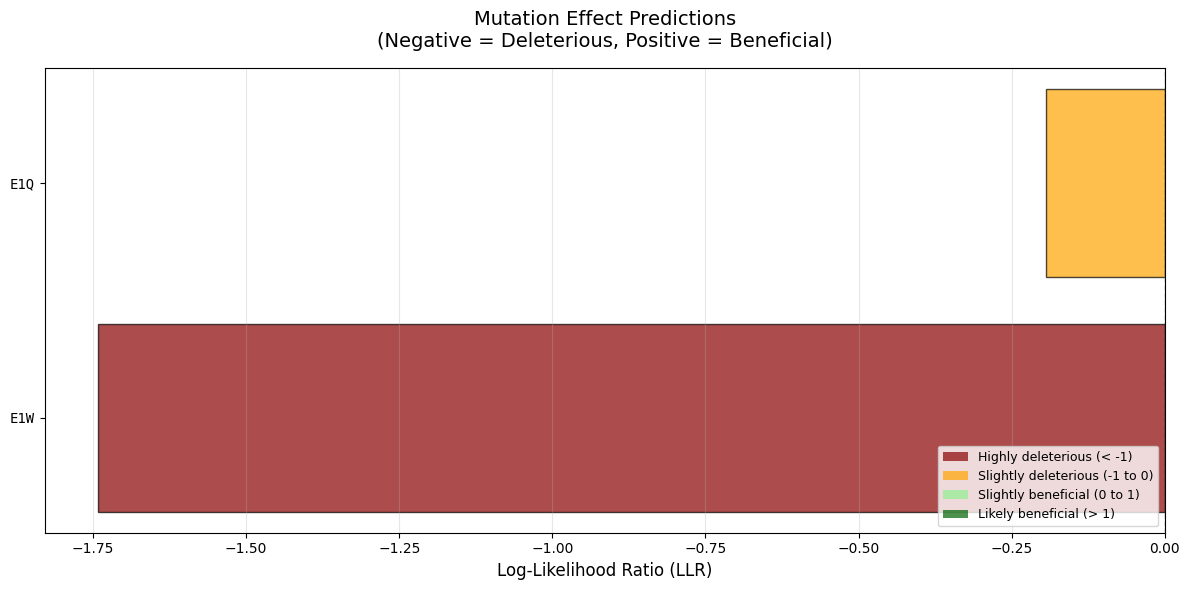

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by LLR for better visualization
sorted_df = mutation_scores_df.sort_values('LLR')

# Color bars by effect
colors = ['darkred' if x < -1 else 'orange' if x < 0 else 'lightgreen' if x < 1 else 'darkgreen'
          for x in sorted_df['LLR']]

bars = ax.barh(range(len(sorted_df)), sorted_df['LLR'], color=colors, alpha=0.7, edgecolor='black')

# Add mutation labels
ax.set_yticks(range(len(sorted_df)))
ax.set_yticklabels(sorted_df['Mutation'], fontsize=10, family='monospace')

# Add vertical line at 0
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Labels and title
ax.set_xlabel('Log-Likelihood Ratio (LLR)', fontsize=12)
ax.set_title('Mutation Effect Predictions\n(Negative = Deleterious, Positive = Beneficial)',
             fontsize=14, pad=15)

# Add grid
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkred', alpha=0.7, label='Highly deleterious (< -1)'),
    Patch(facecolor='orange', alpha=0.7, label='Slightly deleterious (-1 to 0)'),
    Patch(facecolor='lightgreen', alpha=0.7, label='Slightly beneficial (0 to 1)'),
    Patch(facecolor='darkgreen', alpha=0.7, label='Likely beneficial (> 1)'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

## Part 5: Approach 3 - Pseudo-Perplexity (PPPL)

Pseudo-perplexity evaluates the **overall quality** of an entire sequence, not just single mutations.
It's useful for:
- Comparing multiple sequence variants
- Evaluating designed sequences
- Quality control before experimental validation

### Algorithm

For each position i in the sequence:
1. Mask position i
2. Predict the probability of the actual amino acid
3. Take the log probability

PPPL = exp(-1/N × Σ log P(actual_aa_i | context))

**Lower PPPL = more natural sequence**

In [13]:
def compute_pseudo_perplexity(sequence, model, tokenizer, device):
    """
    Compute pseudo-perplexity for a protein sequence.

    Args:
        sequence: Protein sequence
        model: ESM model
        tokenizer: ESM tokenizer
        device: torch device

    Returns:
        pppl: Pseudo-perplexity score
        per_position_ll: Log-likelihood for each position
    """
    model.eval()

    n_positions = len(sequence)
    log_likelihoods = []

    for pos in range(n_positions):
        # Mask position
        masked_seq = sequence[:pos] + tokenizer.mask_token + sequence[pos+1:]

        # Tokenize
        tokens = tokenizer(masked_seq, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}

        # Get predictions
        with torch.no_grad():
            outputs = model(**tokens)
            logits = outputs.logits

        # Find masked position
        mask_idx = (tokens['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1][0]

        # Get log probability of actual amino acid
        log_probs = F.log_softmax(logits[0, mask_idx], dim=0)
        actual_aa = sequence[pos]
        actual_token_id = tokenizer.convert_tokens_to_ids(actual_aa)
        log_likelihood = log_probs[actual_token_id].item()

        log_likelihoods.append(log_likelihood)

    # Compute pseudo-perplexity
    mean_ll = np.mean(log_likelihoods)
    pppl = np.exp(-mean_ll)

    return pppl, np.array(log_likelihoods)

# Compute PPPL for wild-type
print("Computing pseudo-perplexity for wild-type sequence...")
wt_pppl, wt_ll = compute_pseudo_perplexity(wild_type_sequence, model, tokenizer, device)

print(f"\nWild-type sequence:")
print(f"  Length: {len(wild_type_sequence)} aa")
print(f"  Pseudo-perplexity: {wt_pppl:.4f}")
print(f"  Mean log-likelihood: {wt_ll.mean():.4f}")
print(f"\nInterpretation:")
print(f"  Lower PPPL = more 'natural' sequence")
print(f"  Typical range: 1.5 - 20 (depends on protein family)")

Computing pseudo-perplexity for wild-type sequence...

Wild-type sequence:
  Length: 66 aa
  Pseudo-perplexity: 8.9383
  Mean log-likelihood: -2.1903

Interpretation:
  Lower PPPL = more 'natural' sequence
  Typical range: 1.5 - 20 (depends on protein family)


### Compare Multiple Sequences

Let's create a few mutant sequences and compare their PPPL scores.

In [14]:
# Create mutant sequences
mutant_sequences = {
    'Wild-Type': wild_type_sequence,
    'Conservative (K46R)': wild_type_sequence[:45] + 'R' + wild_type_sequence[46:],
    'Radical (E1W)': 'W' + wild_type_sequence[1:],
    'Multiple Mutations': wild_type_sequence[:45] + 'R' + wild_type_sequence[46:49] + 'N' + wild_type_sequence[50:],
}

# Compute PPPL for each
pppl_results = []

for name, seq in mutant_sequences.items():
    print(f"\nScoring: {name}...")
    pppl, ll = compute_pseudo_perplexity(seq, model, tokenizer, device)
    pppl_results.append({
        'Variant': name,
        'PPPL': pppl,
        'Mean_LL': ll.mean(),
    })

pppl_df = pd.DataFrame(pppl_results)
pppl_df = pppl_df.sort_values('PPPL')

print("\n\nPseudo-perplexity Comparison:")
print("=" * 60)
print(pppl_df.to_string(index=False))
print("\nLower PPPL indicates more natural/stable sequence")


Scoring: Wild-Type...

Scoring: Conservative (K46R)...

Scoring: Radical (E1W)...

Scoring: Multiple Mutations...


Pseudo-perplexity Comparison:
            Variant     PPPL   Mean_LL
          Wild-Type 8.938255 -2.190340
 Multiple Mutations 9.014763 -2.198864
      Radical (E1W) 9.173849 -2.216357
Conservative (K46R) 9.223431 -2.221747

Lower PPPL indicates more natural/stable sequence


### Visualize Per-Position Contributions

We can see which positions contribute most to the PPPL score.

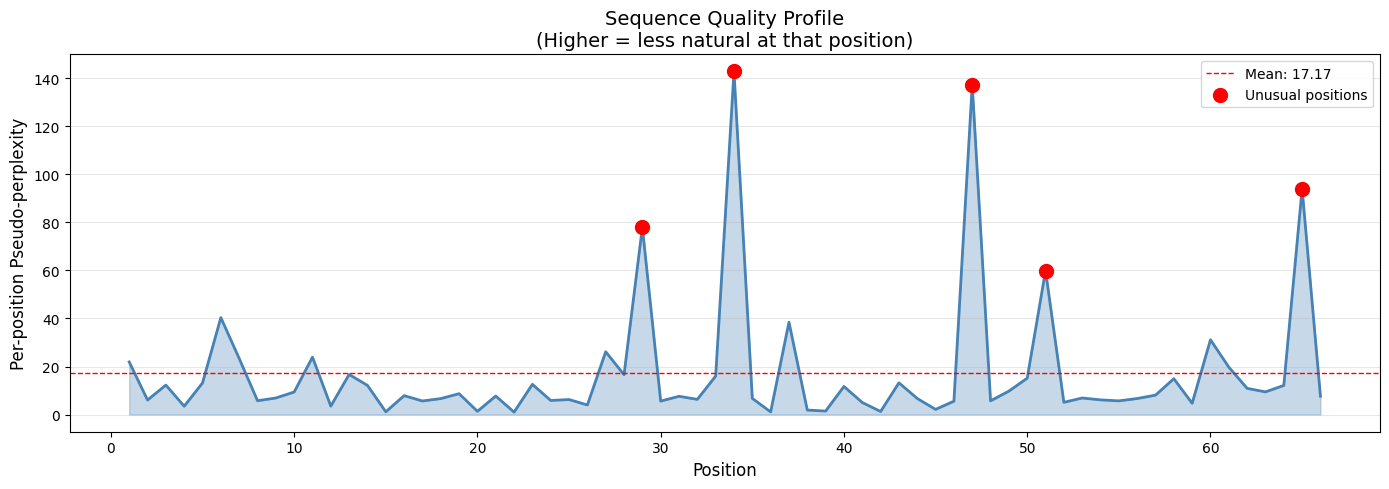


Positions with unusually high PPPL (potentially problematic):
  Position 29: F (PPPL = 77.97)
  Position 34: M (PPPL = 142.82)
  Position 47: W (PPPL = 137.29)
  Position 51: I (PPPL = 59.91)
  Position 65: K (PPPL = 93.94)


In [15]:
# Get per-position scores for wild-type
_, wt_per_pos = compute_pseudo_perplexity(wild_type_sequence, model, tokenizer, device)

# Plot
fig, ax = plt.subplots(figsize=(14, 5))

# Convert to per-position perplexity
per_pos_pppl = np.exp(-wt_per_pos)

positions = np.arange(1, len(wild_type_sequence) + 1)
ax.plot(positions, per_pos_pppl, linewidth=2, color='steelblue')
ax.fill_between(positions, per_pos_pppl, alpha=0.3, color='steelblue')

# Add horizontal line at mean
mean_pppl = per_pos_pppl.mean()
ax.axhline(y=mean_pppl, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_pppl:.2f}')

# Highlight high-scoring (problematic) positions
threshold = mean_pppl + per_pos_pppl.std()
problematic = per_pos_pppl > threshold
ax.scatter(positions[problematic], per_pos_pppl[problematic],
           color='red', s=100, zorder=5, label='Unusual positions')

ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Per-position Pseudo-perplexity', fontsize=12)
ax.set_title('Sequence Quality Profile\n(Higher = less natural at that position)', fontsize=14)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPositions with unusually high PPPL (potentially problematic):")
for pos in positions[problematic]:
    aa = wild_type_sequence[pos-1]
    score = per_pos_pppl[pos-1]
    print(f"  Position {pos}: {aa} (PPPL = {score:.2f})")

## Part 6: Practical Application - Antibody Optimization

Let's apply these methods to a real-world scenario: improving an antibody's properties while
maintaining binding specificity.

### Scenario
We have an antibody that binds our target but has:
- Suboptimal stability
- Potential immunogenic hotspots

Goal: Identify mutations that:
1. Don't disrupt conserved binding residues (CDRs)
2. Improve overall sequence quality
3. Remove unusual/immunogenic patterns

In [16]:
# Identify framework vs CDR regions (simplified annotation)
# In real antibodies, CDRs are positions ~26-33, 51-57, 96-102 (Kabat numbering)
# For our sequence, let's mark some regions as "critical" (CDR-like)
critical_positions = list(range(14, 22)) + list(range(40, 48))  # Example CDR positions

print("Critical positions (conserved, binding-related):")
print(f"  {critical_positions}")
print(f"  These positions: {[wild_type_sequence[i] for i in critical_positions]}")

Critical positions (conserved, binding-related):
  [14, 15, 16, 17, 18, 19, 20, 21, 40, 41, 42, 43, 44, 45, 46, 47]
  These positions: ['G', 'G', 'S', 'L', 'R', 'L', 'S', 'C', 'P', 'G', 'K', 'G', 'L', 'E', 'W', 'V']


### Strategy: Find Stabilizing Mutations Outside CDRs

In [17]:
# Find positions outside CDRs that tolerate beneficial mutations
optimization_candidates = []

for pos in range(len(wild_type_sequence)):
    if pos in critical_positions:
        continue  # Skip critical positions

    wt_aa = wild_type_sequence[pos]
    pos_scores = mutation_scores[:, pos]

    # Find amino acids with positive LLR (potentially beneficial)
    for aa_idx, aa in enumerate(amino_acids):
        if aa == wt_aa:
            continue

        llr = pos_scores[aa_idx]
        if llr > 0.5:  # Threshold for "beneficial"
            optimization_candidates.append({
                'Position': pos + 1,
                'Wild-Type': wt_aa,
                'Mutant': aa,
                'LLR': llr,
                'Mutation': f"{wt_aa}{pos+1}{aa}"
            })

# Sort by LLR
optimization_df = pd.DataFrame(optimization_candidates)
optimization_df = optimization_df.sort_values('LLR', ascending=False).head(15)

print("\nTop 15 optimization candidates (outside critical regions):")
print("=" * 70)
print(optimization_df.to_string(index=False))


Top 15 optimization candidates (outside critical regions):
 Position Wild-Type Mutant      LLR Mutation
       34         M      V 3.898732     M34V
       34         M      F 3.603183     M34F
       34         M      Y 2.935414     M34Y
       34         M      L 2.876054     M34L
       29         F      G 2.846798     F29G
       37         V      Y 2.770144     V37Y
       29         F      S 2.682704     F29S
        7         S      P 2.585356      S7P
       34         M      I 2.473511     M34I
       65         K      S 2.425037     K65S
       65         K      D 2.391597     K65D
       65         K      V 2.290740     K65V
       51         I      S 2.258462     I51S
       51         I      G 2.218906     I51G
       65         K      L 2.170876     K65L


### Evaluate Combined Mutations

Let's create a sequence with multiple beneficial mutations and check its PPPL.

In [18]:
# Select top 3 non-overlapping mutations
top_mutations = optimization_df.head(3)

# Create optimized sequence
optimized_sequence = list(wild_type_sequence)
for _, row in top_mutations.iterrows():
    pos = row['Position'] - 1
    mt = row['Mutant']
    optimized_sequence[pos] = mt

optimized_sequence = ''.join(optimized_sequence)

print("Optimized sequence (with 3 mutations):")
print(f"  Mutations: {', '.join(top_mutations['Mutation'].tolist())}")

# Compare PPPL
wt_pppl_final, _ = compute_pseudo_perplexity(wild_type_sequence, model, tokenizer, device)
opt_pppl, _ = compute_pseudo_perplexity(optimized_sequence, model, tokenizer, device)

print(f"\nPseudo-perplexity comparison:")
print(f"  Wild-type:  {wt_pppl_final:.4f}")
print(f"  Optimized:  {opt_pppl:.4f}")
print(f"  Change:     {opt_pppl - wt_pppl_final:+.4f}")

if opt_pppl < wt_pppl_final:
    print(f"\n✓ Optimized sequence is MORE natural (lower PPPL)")
else:
    print(f"\n✗ Optimized sequence is LESS natural (higher PPPL)")

Optimized sequence (with 3 mutations):
  Mutations: M34V, M34F, M34Y

Pseudo-perplexity comparison:
  Wild-type:  8.9383
  Optimized:  8.8679
  Change:     -0.0704

✓ Optimized sequence is MORE natural (lower PPPL)


## Part 7: Model Size Comparison

Different ESM-2 model sizes offer trade-offs between speed and accuracy. Let's demonstrate
how to quickly switch models.

In [19]:
def compare_model_sizes(sequence, mutation, model_names):
    """
    Score a single mutation using different model sizes.

    Args:
        sequence: Wild-type sequence
        mutation: Mutation string (e.g., "A5G")
        model_names: List of model names to compare

    Returns:
        DataFrame with comparison results
    """
    results = []

    # Parse mutation
    wt_aa = mutation[0]
    pos = int(mutation[1:-1]) - 1
    mt_aa = mutation[-1]

    for model_name in model_names:
        print(f"Loading {model_name}...")

        # Load model
        tok = AutoTokenizer.from_pretrained(model_name)
        mdl = EsmForMaskedLM.from_pretrained(model_name)
        mdl = mdl.to(device)
        mdl.eval()

        # Time the scoring
        import time
        start = time.time()

        # Mask and score
        masked_seq = sequence[:pos] + tok.mask_token + sequence[pos+1:]
        tokens = tok(masked_seq, return_tensors="pt")
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            outputs = mdl(**tokens)

        mask_idx = (tokens['input_ids'] == tok.mask_token_id).nonzero(as_tuple=True)[1][0]
        log_probs = F.log_softmax(outputs.logits[0, mask_idx], dim=0)

        wt_token_id = tok.convert_tokens_to_ids(wt_aa)
        mt_token_id = tok.convert_tokens_to_ids(mt_aa)

        llr = log_probs[mt_token_id].item() - log_probs[wt_token_id].item()

        elapsed = time.time() - start

        results.append({
            'Model': model_name.split('/')[-1],
            'Parameters': sum(p.numel() for p in mdl.parameters()),
            'LLR': llr,
            'Time (s)': elapsed,
        })

        # Clean up
        del mdl, tok
        torch.cuda.empty_cache()

    return pd.DataFrame(results)

# Compare models (only if you have enough memory)
print("\nComparing ESM-2 model sizes...")
print("(This may take a few minutes and requires significant GPU memory)")

# Uncomment to run comparison (requires sufficient GPU memory)
# model_comparison = compare_model_sizes(
#     wild_type_sequence,
#     "E1W",
#     ["facebook/esm2_t6_8M_UR50D",
#      "facebook/esm2_t12_35M_UR50D",
#      "facebook/esm2_t30_150M_UR50D"]
# )
# print("\n", model_comparison.to_string(index=False))


Comparing ESM-2 model sizes...
(This may take a few minutes and requires significant GPU memory)


## Part 8: Export Results for Experimental Validation

Let's create a comprehensive report that experimentalists can use to prioritize mutations.

In [20]:
# Create comprehensive report
report = []

for pos in range(len(wild_type_sequence)):
    wt_aa = wild_type_sequence[pos]
    is_critical = pos in critical_positions

    # Get top 3 best and worst mutations
    pos_scores = mutation_scores[:, pos]

    for aa_idx, aa in enumerate(amino_acids):
        if aa == wt_aa:
            continue

        llr = pos_scores[aa_idx]

        report.append({
            'Mutation': f"{wt_aa}{pos+1}{aa}",
            'Position': pos + 1,
            'WT': wt_aa,
            'MT': aa,
            'LLR': llr,
            'Effect': interpret_mutation_score(llr),
            'Critical_Region': 'Yes' if is_critical else 'No',
            'Priority': 'High' if not is_critical and llr > 0.5 else 'Low'
        })

report_df = pd.DataFrame(report)

# Save to CSV
report_df.to_csv('mutation_report.csv', index=False)
print("Full report saved to: mutation_report.csv")

# Show summary
print("\nSummary statistics:")
print(f"  Total mutations evaluated: {len(report_df)}")
print(f"  Predicted deleterious: {(report_df['LLR'] < -1).sum()}")
print(f"  Predicted neutral: {((report_df['LLR'] >= -1) & (report_df['LLR'] < 1)).sum()}")
print(f"  Predicted beneficial: {(report_df['LLR'] >= 1).sum()}")
print(f"\n  High priority candidates (beneficial, non-critical): {(report_df['Priority'] == 'High').sum()}")

# Show top recommendations
print("\nTop 10 recommended mutations for experimental testing:")
print("=" * 90)
recommendations = report_df[report_df['Priority'] == 'High'].nlargest(10, 'LLR')
print(recommendations[['Mutation', 'LLR', 'Effect', 'Critical_Region']].to_string(index=False))

Full report saved to: mutation_report.csv

Summary statistics:
  Total mutations evaluated: 1254
  Predicted deleterious: 767
  Predicted neutral: 416
  Predicted beneficial: 71

  High priority candidates (beneficial, non-critical): 110

Top 10 recommended mutations for experimental testing:
Mutation      LLR            Effect Critical_Region
    M34V 3.898732 Likely beneficial              No
    M34F 3.603183 Likely beneficial              No
    M34Y 2.935414 Likely beneficial              No
    M34L 2.876054 Likely beneficial              No
    F29G 2.846798 Likely beneficial              No
    V37Y 2.770144 Likely beneficial              No
    F29S 2.682704 Likely beneficial              No
     S7P 2.585356 Likely beneficial              No
    M34I 2.473511 Likely beneficial              No
    K65S 2.425037 Likely beneficial              No


## Summary and Best Practices

### Key Takeaways

1. **Log-Likelihood Ratios (LLRs)** quantify mutation effects:
   - Negative = deleterious
   - ~0 = neutral
   - Positive = potentially beneficial

2. **Three complementary approaches**:
   - **Heatmap**: Comprehensive view of mutation landscape
   - **Masked marginals**: Accurate scoring of specific mutations (recommended)
   - **Pseudo-perplexity**: Overall sequence quality assessment

3. **Model selection matters**:
   - t12_35M: Good for most tasks, Colab-friendly
   - t33_650M: Best accuracy, requires more GPU memory
   - t6_8M: Quick prototyping

### Best Practices

**For protein engineering**:
- Start with heatmap to identify conserved regions
- Use masked marginals to score candidate mutations
- Validate with PPPL for combined mutations
- Prioritize mutations outside functional sites

**For disease variant interpretation**:
- Highly negative LLR (< -2) → likely pathogenic
- Consider structural context (not just sequence)
- Combine with other predictors (SIFT, PolyPhen, etc.)

**For antibody optimization**:
- Protect CDR regions (binding sites)
- Target framework regions for stability improvements
- Check PPPL of final design
- Validate developability (aggregation, immunogenicity)

### Limitations

1. **Zero-shot predictions**: No experimental data for your specific protein
2. **Sequence-based**: Doesn't consider 3D structure explicitly
3. **Correlative**: Scores reflect evolutionary patterns, not mechanisms
4. **Context-dependent**: Same mutation may have different effects in different proteins

### When to Combine with Other Methods

- **Structure prediction** (ESMFold, AlphaFold): Understand structural impact
- **Molecular dynamics**: Evaluate stability changes
- **Experimental screens**: Validate top predictions
- **MSA-based methods**: Use ESM-MSA-1b if homologs available

## Conclusion

You've now learned how to use ESM-2 for comprehensive mutation effect prediction!

**What you can do**:
- ✓ Create mutation heatmaps showing effects across entire sequences
- ✓ Score specific mutations with three different strategies
- ✓ Evaluate sequence quality with pseudo-perplexity
- ✓ Optimize proteins for stability and function
- ✓ Prioritize mutations for experimental validation

**Remember**: These are predictions based on evolutionary patterns. Always validate
critical mutations experimentally. But as a screening and prioritization tool,
ESM-2 can dramatically reduce the experimental search space!